In [1]:
import torch
import pandas as pd
import astropy as ap
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
# from astropy.io import fits
import pdb
from scipy.ndimage.filters import maximum_filter1d
import glob
import fitsio as fits
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data_utils
from torch.nn.utils import clip_grad_norm_
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence, pad_sequence
from torch.distributions.normal import Normal
from tqdm import tqdm
from loading import TessDataset
from ode_rnn import create_ODERNN_model
from utils import process_gaia_csv, collate_2d

In [2]:
import sys
sys.path.insert(0, '../')
sys.path.insert(1, '../latent_ode/')
import latent_ode.lib as ode
import latent_ode.lib.utils as utils
from latent_ode.lib.latent_ode import LatentODE
from latent_ode.lib.ode_rnn import ODE_RNN
from latent_ode.lib.encoder_decoder import Encoder_z0_ODE_RNN, Decoder
from latent_ode.lib.diffeq_solver import DiffeqSolver
from latent_ode.lib.ode_func import ODEFunc

### Load Model

In [3]:
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = torch.device("cpu")

In [4]:
# Options
input_dim = 2
n_labels = 1
status_properties = ['loss', 'ratio']
latent_dim = 40

In [5]:
model = create_ODERNN_model()

In [6]:
model_file = 'ode_rnn_state_gaia2d.pth.tar'

In [7]:
state = torch.load(model_file, map_location=torch.device('cpu'))

In [8]:
model.load_state_dict(state['state_dict'])

<All keys matched successfully>

### Calc vecs

In [9]:
files = glob.glob('gaia/gdr2/light_curves/csv/light_curves*.csv')

In [10]:
df = process_gaia_csv(files[-3])

In [11]:
def fmt_inp(df):
    grouped = df.groupby(['source_id','band','time_resampled'])['scaled'].mean()
    grouped = grouped.unstack(2).fillna(0).stack()
    grouped.fillna(0, inplace=True)
    grouped.name = 'scaled'
    grouped = grouped.unstack(1).reset_index().groupby(['source_id'])[['time_resampled','BP','RP']].apply(
        lambda x: sorted(list(x.values.astype(np.float32)), key=lambda x: x[0]))
    ids = list(grouped.index)
    vs = []
    for v in grouped.values:
        v = torch.FloatTensor(v)
        vs.append(v)
    x = torch.stack(vs)
    x = x.permute(0, 2, 1)
    inputs = collate_2d(x)
    return ids, inputs

In [12]:
def calc(inputs):
    observed = inputs['observed_data']#.to(device)
    mask = inputs['observed_mask']#.to(device)
    t = inputs['observed_tp']
    x = torch.cat((observed, mask), -1)
#     try:
#         z_u, z_std = model.encoder_z0.forward(x, t)
#     except:
    z_u, z_std = model.ode_gru.forward(x, t)
    return z_u

In [13]:
vecs = {}
for file in tqdm(files):
    df = process_gaia_csv(file)
    if df.empty:
        continue
    ids, inputs = fmt_inp(df)
    zs = calc(inputs)
    zs = zs.squeeze().detach().cpu().numpy()
    res = zip(ids, zs)
    vecs.update(res)

 19%|█▉        | 105/550 [02:01<08:14,  1.11s/it]

KeyboardInterrupt: 

In [ ]:
break

### Parallel

In [ ]:
from multiprocessing.pool import Pool

In [ ]:
pool = Pool(8)

In [ ]:
def func(file):
    df = process_gaia_csv(file)
    if df.empty:
        return
    ids, inputs = fmt_inp(df)
    zs = calc(inputs)
    zs = zs.squeeze().detach().cpu().numpy()
    res = zip(ids, zs)
    return res

In [ ]:
a = pool.map(func, files)

In [ ]:
pool.close()
pool.join()

In [ ]:
len(a)

### Analysis

In [14]:
from sklearn.manifold import TSNE

In [15]:
tsne = TSNE(perplexity=30)

In [16]:
vs = np.stack([v for v in vecs.values()])

In [17]:
vs.shape

(15833, 40)

In [19]:
xs = tsne.fit_transform(vs)

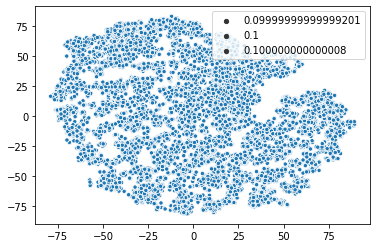

In [20]:
sns.scatterplot(x=xs[:,0], y=xs[:,1], size=0.1)